In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


import statsmodels.tsa.api as smt
import statsmodels.api as sm


import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Importing everything from forecasting quality metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams.update({"figure.figsize":(9,3),
                     "figure.dpi":120})


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def acf_and_pacf(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 1)

        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 0))
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

# SARIMA ACF AND PACF

In Seasonal ARIMA, the model parameter selection is carrried out through two plots named ACF and PACF. ACF stands for Auto-correlation  and PACF stands for partial auto-correlation function. Autc-correlation function is used find how correlated lags (points) are with one another whereas Partial Auto-correlation function determines the correlation between two lags that are separated by a larger periods.


In [ ]:
df = pd.read_csv("Final_Day.csv")
time_column_name = df.columns[0]

df[time_column_name] = pd.to_datetime(df[time_column_name], format="%Y-%m-%d %H:%M")
df.set_index(time_column_name, inplace=True)

df = df[df.index.year == 2020]

df = df[~df.index.duplicated(keep='first')]

print("NAN values before interpolation: ",df.isna().sum().sum())
df = df.interpolate(method="cubic")
print("After interpolation: ",df.isna().sum().sum())
print(df.columns)
print(df)

NAN values before interpolation:  1
After interpolation:  0
Index(['Day-ahead Price [EUR/MWh]'], dtype='object')
                     Day-ahead Price [EUR/MWh]
MTU (CET)                                     
2020-01-01 00:00:00                      41.88
2020-01-01 01:00:00                      38.60
2020-01-01 02:00:00                      36.55
2020-01-01 03:00:00                      32.32
2020-01-01 04:00:00                      30.85
...                                        ...
2020-04-02 19:00:00                      25.82
2020-04-02 20:00:00                      27.30
2020-04-02 21:00:00                      24.47
2020-04-02 22:00:00                      25.00
2020-04-02 23:00:00                      24.50

[2232 rows x 1 columns]


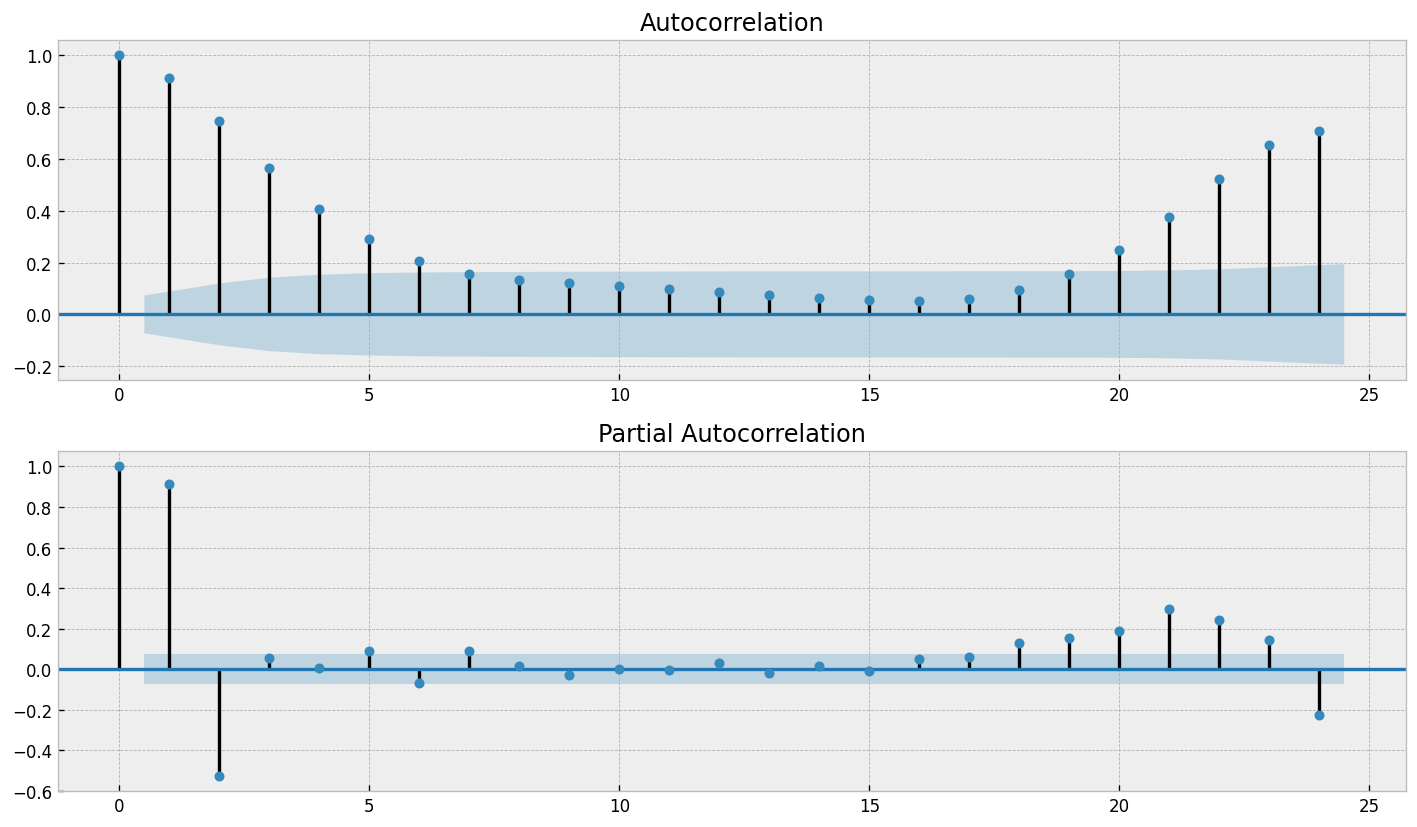

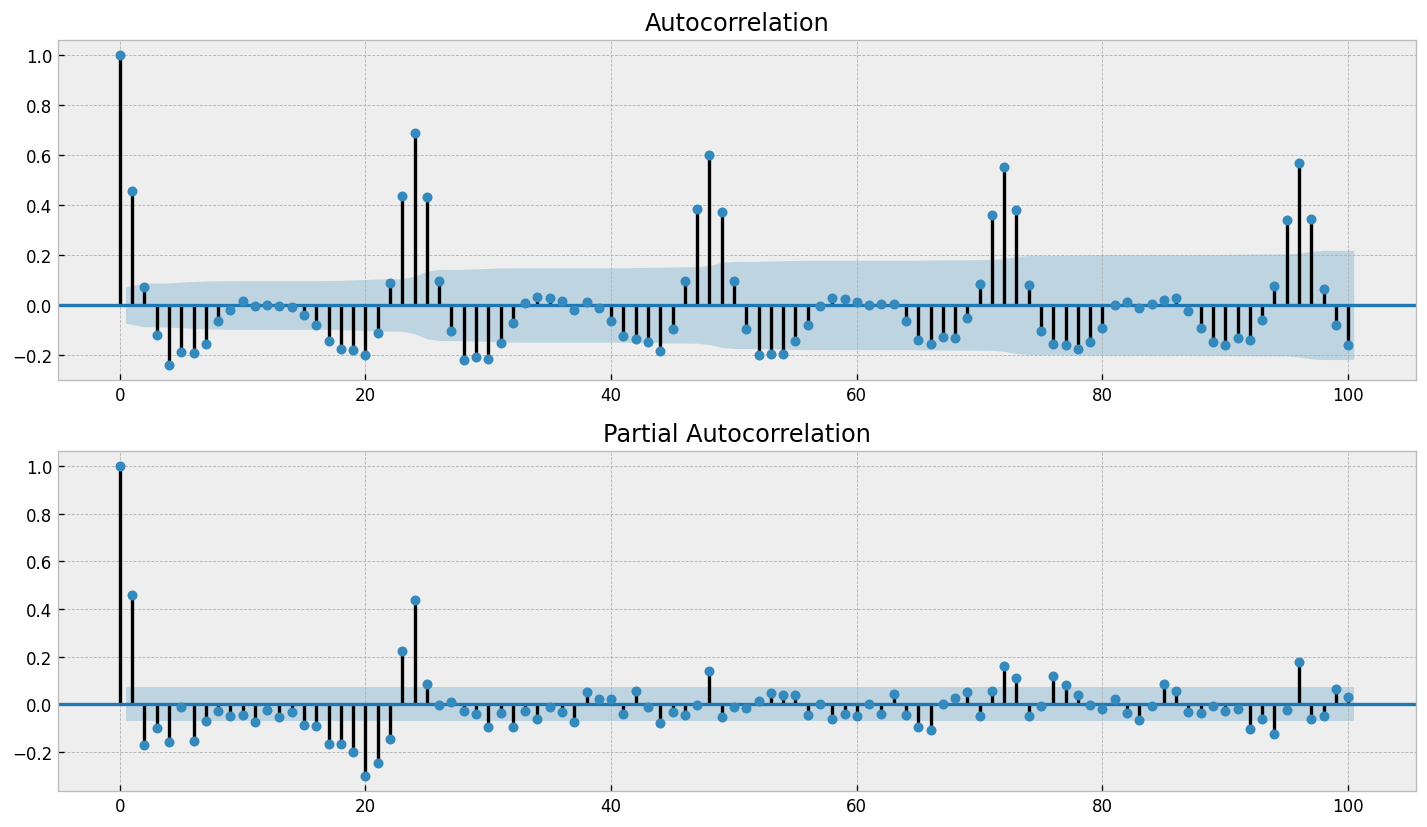

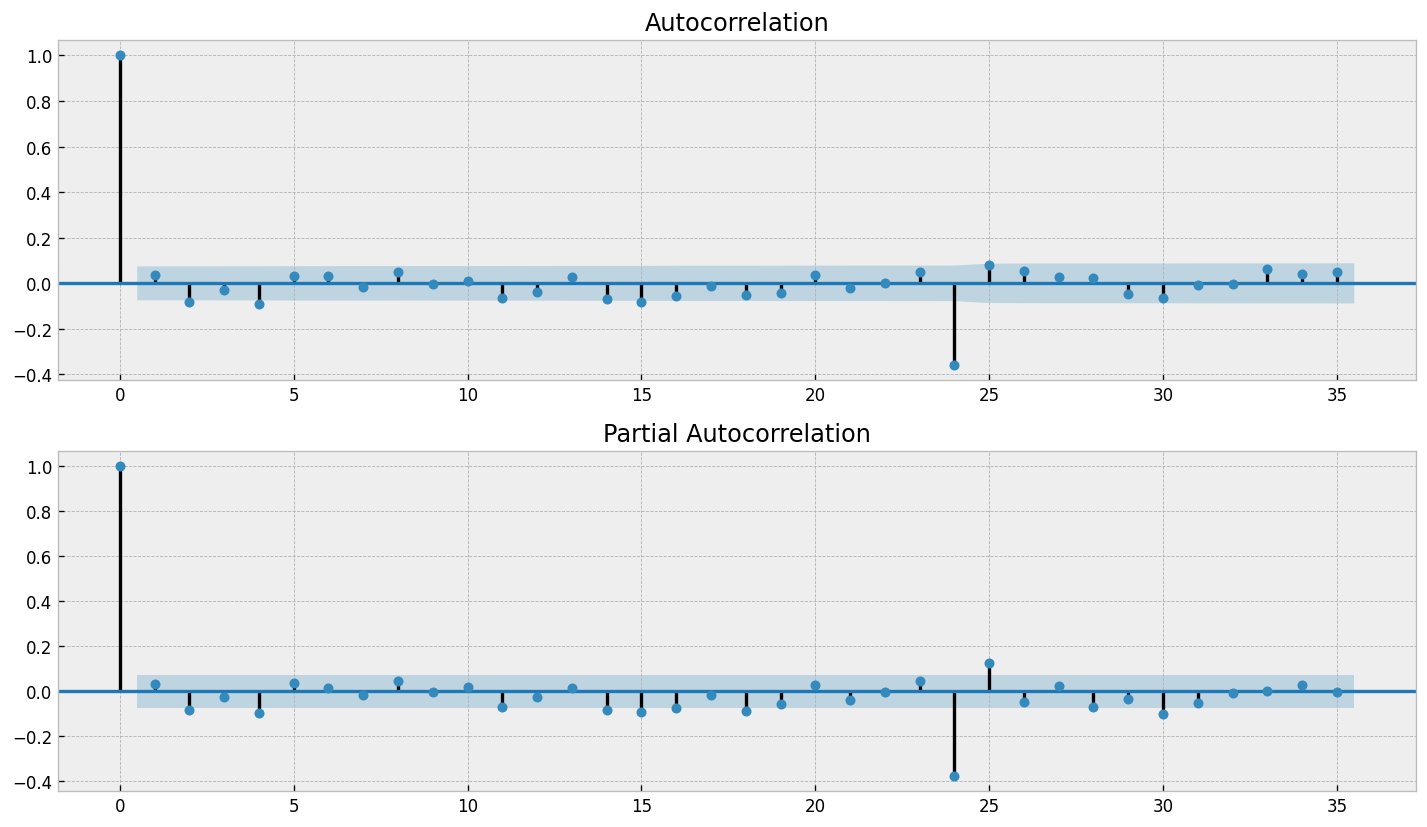

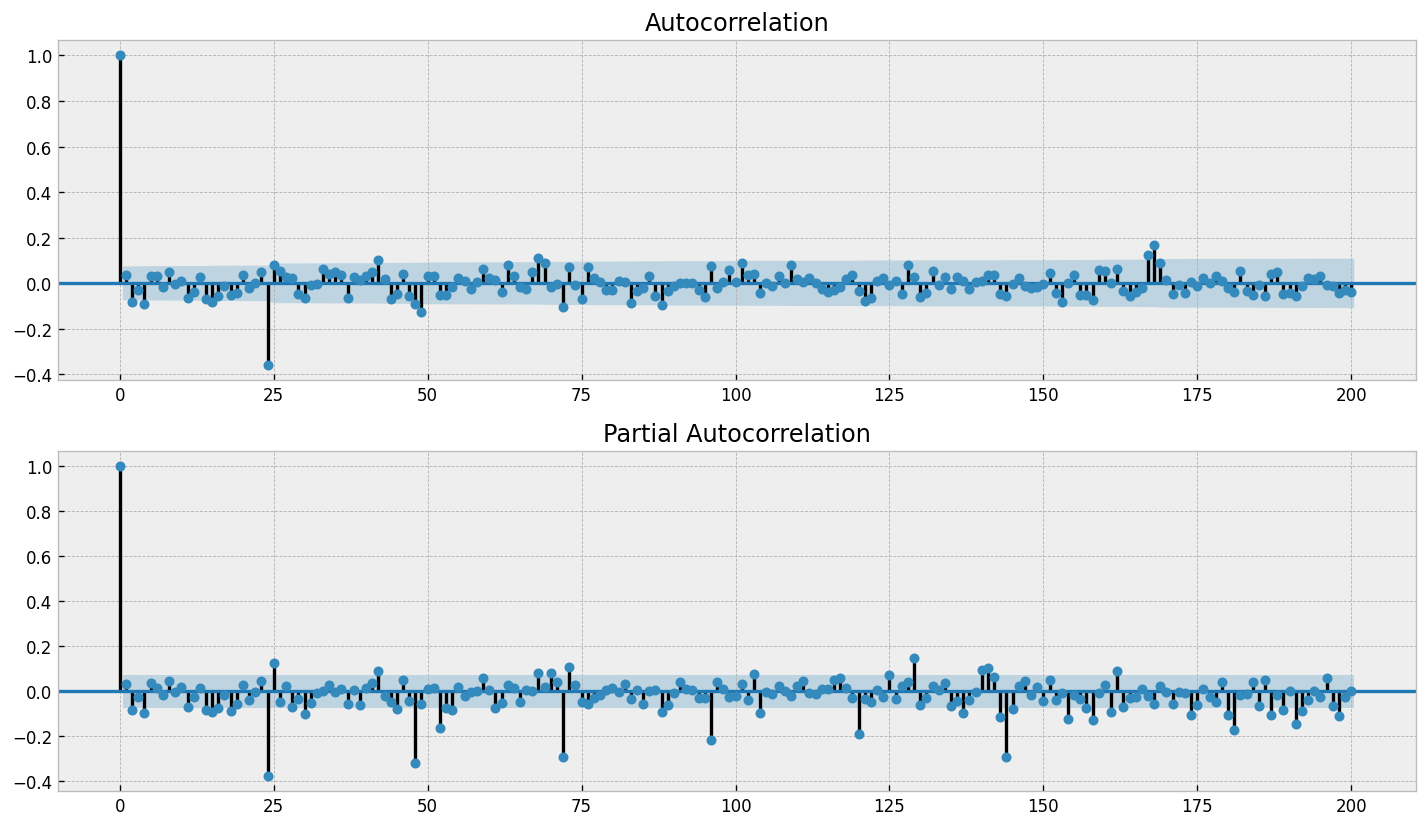

In [ ]:
temp_df = df.iloc[:720,0].values
temp_df_diff = df.iloc[:720,0].diff().dropna().values
temp_df_diff_diff = df.iloc[:720,0].diff().dropna().diff(24).dropna().values


acf_and_pacf(temp_df, lags = 24)
#plt.show()
plt.savefig("sarimaseasonal1.pdf")

acf_and_pacf(temp_df_diff, lags = 100)
plt.savefig("sarimaseasonal2.pdf")

#plt.show()

acf_and_pacf(temp_df_diff_diff, lags = 35)
#plt.show()

acf_and_pacf(temp_df_diff_diff, lags = 200)
#plt.show()
plt.savefig("sarimaseasonal3.pdf")

In [ ]:
# SARIMA Model
# p = 1
# q = 1
# d = 1
# P = 6
# Q = 1
# D = 1

#sarimax = SARIMAX(df.iloc[:720,0],order=(1,1,1),seasonal_order=(4,1,1,24)).fit(disp=0, maxiter = 1)
#print(sarimax.aic)

In [ ]:
train = df.loc["2020-02-03 23:00:00":"2020-03-03 23:00:00"]
test = [float(x) for x in df.loc["2020-03-04 00:00:00":"2020-03-24"].values ]

print(len(test))
print(train)

# prepare training dataset
# training_size = int(len(X[0]) * sample_size)
# train = X[0][-training_size:]
# test = X[1]

history = [float(x) for x in train.values]
# make predictions
predictions = list()

for t in range(len(test)):
    sarimax = SARIMAX(history,order=(1,1,1),seasonal_order=(3,1,1,24)).fit(disp=0, maxiter = 1)
    yhat = sarimax.forecast()[0]

    print("beginning: ", history[0])    
    predictions.append(yhat)
    history.append(test[t])
    history.pop(0)
    print("MAE: ",yhat, " / ", test[t]," : ",mean_absolute_error([test[t]],[yhat]))
    print("beginning after pop: ", history[0])
    
# calculate out of sample error
error = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
print("Error: ", mae)

504
                     Day-ahead Price [EUR/MWh]
MTU (CET)                                     
2020-02-03 23:00:00                      24.76
2020-02-04 00:00:00                      20.79
2020-02-04 01:00:00                      17.41
2020-02-04 02:00:00                      16.24
2020-02-04 03:00:00                      11.90
...                                        ...
2020-03-03 19:00:00                      56.90
2020-03-03 20:00:00                      40.93
2020-03-03 21:00:00                      38.19
2020-03-03 22:00:00                      35.03
2020-03-03 23:00:00                      31.29

[697 rows x 1 columns]
beginning:  24.76
MAE:  28.30584608360942  /  30.1  :  1.7941539163905809
beginning after pop:  20.79
beginning:  20.79
MAE:  28.50364492142869  /  28.1  :  0.4036449214286897
beginning after pop:  17.41
beginning:  17.41
MAE:  27.521220351182063  /  27.08  :  0.44122035118206426
beginning after pop:  16.24
beginning:  16.24
MAE:  24.575813786757656  /  26.8 

In [ ]:
print(mae)

2.542889647499942


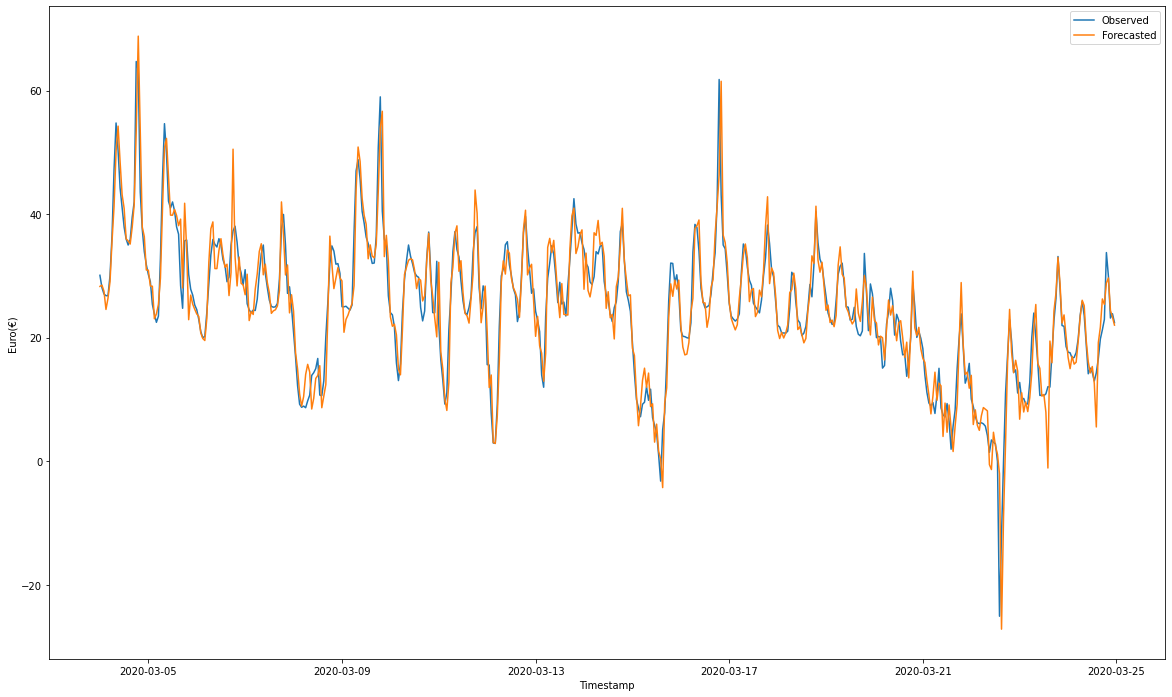

In [ ]:
result_timestamp = df.loc["2020-03-04 00:00:00":"2020-03-24"].index

plt.plot(result_timestamp, test, label = "Observed")
plt.plot(result_timestamp, predictions, label = "Forecasted")
plt.xlabel("Timestamp")
plt.ylabel("Euro(€)")
plt.legend()

plt.savefig("sarimaforecast.pdf")
#plt.show()